In [2]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stat
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from multiprocessing import Pool
from scipy import stats
from scipy.optimize import curve_fit
import pandas as pd
import seaborn as sns
import statsmodels

# Lineplots first!
## Odd is Accuracy Even is Speed

## 0 1 are sudden

In [2]:
def lineplots(data, block, first, last):
    traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))

    for i in range(first,last):
        plt.plot(traj['x'][0][i][0], traj['y'][0][i][0])


In [3]:
interact(lineplots, data = widgets.ToggleButtons(options = range(1000, 1060)), block = widgets.IntSlider(max = 11, min = 0, value = 0, step = 1),
        first = widgets.IntSlider(max = 63, min = 0, value = 0, step = 1), last = widgets.IntSlider(max = 64, min = 1, value = 1, step = 1))

interactive(children=(ToggleButtons(description='data', options=(1000, 1001, 1002, 1003, 1004, 1005, 1006, 100…

<function __main__.lineplots(data, block, first, last)>

## Error Vs Time plots

Divide Trajectories by 5. Calculate mean and standard deviation of difference between ideal and actual trajectories (both divided by 5) for all 64 trajectories in a block. 
From the movement time, calculate how long it took to finish each of these 5 trajectories. Calculate mean and standard deviation across 64 trials. 

This might as well just be equal to the mean and standard deviation of the **number** of points in each of those five quantiles for all trajectories.



# Error Calculation
Takes in a trajectory loaded from the mat file and calculates error by comparing minimum distance from x and y coordinates of the actual trajectory to the ideal trajectory

In [3]:
#square_coord = scipy.io.loadmat('data/pilot/pilot_1/squares/coordinates/squares3.mat')
#traj = scipy.io.loadmat('data/pilot/pilot_1/actual_trajectories/trajectories3.mat')
#def calc_error(traj, square_coord):
# The version above uses square coordinates
def calc_error(traj):    
    error = list()
    for j in range(64):
        traj_dist = list()
        trajx, trajy = traj['x'][0][j][0], traj['y'][0][j][0]
        #end_pointx, end_pointy  = square_coord['squareX'][0][j], square_coord['squareY'][0][j]
        end_pointx, end_pointy  = traj['x'][0][j][0][-1], traj['y'][0][j][0][-1]

        xline = numpy.linspace(0, end_pointx, 500)
        yline = numpy.linspace(0, end_pointy, 500)

        for i in range(len(trajx)):
            xdist = min(numpy.absolute(xline-trajx[i]))
            ydist = min(numpy.absolute(yline-trajy[i]))
            dist = numpy.sqrt(xdist**2 + ydist**2)
            traj_dist.append(dist)
        error.append(traj_dist)
    return error
#dist = numpy.linalg.norm(numpy.cross(p2-p1, p1-p3))/numpy.linalg.norm(p2-p1)

In [19]:
exp_des = pd.DataFrame({'Trial': np.arange(768), 
                        'Gradual': np.hstack((np.repeat(np.arange(0, 100, 10), 64), np.repeat(90, 64), np.repeat(0, 64))), 
                        'Sudden': np.hstack((np.repeat(0, 64), np.repeat(90, 640), np.repeat(0, 64)))
                       
                       })

[Text(0, 0.5, 'Rotation')]

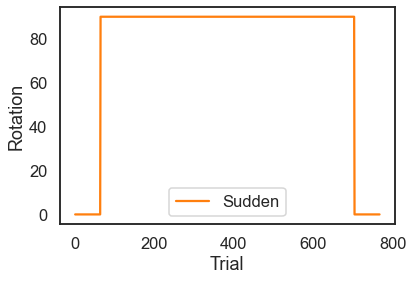

In [31]:
sns.set_context('talk')
sns.set_style('white')
s = sns.lineplot(x = 'Trial', y = 'Sudden', data = exp_des, label = 'Sudden', color = 'C1')
#s = sns.lineplot(x = 'Trial', y = 'Gradual', data = exp_des, label = 'Gradual')
s.set(ylabel = 'Rotation')

In [5]:
#calc_error(traj, square_coord)

Participant 1 Gradual Change Accuracy emphasis

Participant 2 Sudden change Accuracy emphasis

Participant 3 Gradual change Speed emphasis

# Time quintiles:
X axis is cummulative sum of the number of samples in the trajectory, averaged across all trajectories. 
Y axis is the mean of error in that time quantile, averaged across all trajectories


In [6]:
def errorvstime(data, block, num_trajectories):
    traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
    ideal_traj = scipy.io.loadmat('data/data{data}/ideal_trajectories/trajectories{block}.mat'.format(block = str(block), data=str(data)))
    #squares = scipy.io.loadmat('data/participants/data{data}/squares/coordinates/squares{block}.mat'.format(block=str(block), data=str(data)))
    #xdiff = (ideal_traj['idealXs'] - traj['x'])
    #ydiff = (ideal_traj['idealYs'] - traj['y'])
    error = calc_error(traj)[:num_trajectories]
    #error = xdiff**2+ydiff**2
    #print (error)
    error_means = numpy.zeros((num_trajectories, 5))
    for i in range(num_trajectories):
        n = len(error[i])
        for j in range(5):
            error_means[i, j] = numpy.mean(error[i][int(numpy.floor((j)*n/5)):int(numpy.floor((j+1)*n/5))])
#            error_means[i, j] = numpy.median(error[i][int(numpy.floor((j)*n/5)):int(numpy.floor((j+1)*n/5))])
         #error_means[i, ] = error_means[i, ]/max(error_means[i,])

    
    time_means = numpy.zeros((num_trajectories, 5))

    for i in range(num_trajectories):
        n = len(error[i])
        for j in range(5):
            time_means[i, j] = len(error[i][int(numpy.floor((j)*n/5)):int(numpy.floor((j+1)*n/5))])
    times = numpy.cumsum(numpy.mean(time_means, axis = 0))
    plt.errorbar(times, numpy.mean(error_means, axis = 0), xerr = stat.sem(time_means, axis = 0), yerr = stat.sem(error_means, axis = 0))
    plt.ylabel('Error')
    plt.xlabel('Time')
    plt.xlim(0, 100)
    plt.ylim(-20, 70)
    return times, numpy.mean(error_means, axis = 0)

Calculate error vs time for each block collapsed across participants.

C:\Users\Tejas\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Tejas\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


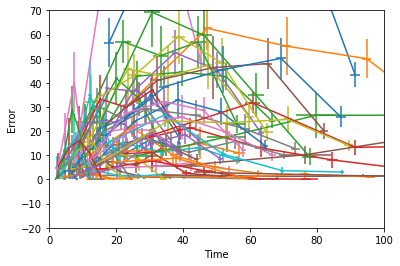

In [7]:
times = numpy.zeros((60, 5))
errors = numpy.zeros((60, 5))
for i in range(1000, 1059):
    temp = errorvstime(i, 11, 32)
    times[i-1000] = temp[0]
    errors[i-1000] = temp[1] 
    #print (i)

In [2]:
errors = pd.read_csv('Curvature_Errors.csv')
errors['Condition'] = errors['Rotation'] + '_' + errors['Emphasis']

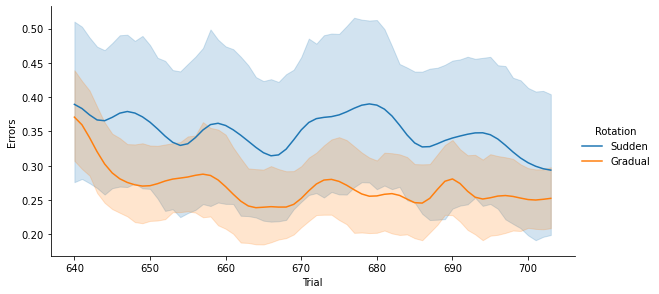

In [3]:
sns.relplot(x = 'Trial', y = 'Errors', hue = 'Rotation', data = errors[errors['Block'] == 10], height = 4, aspect = 2, kind = 'line')

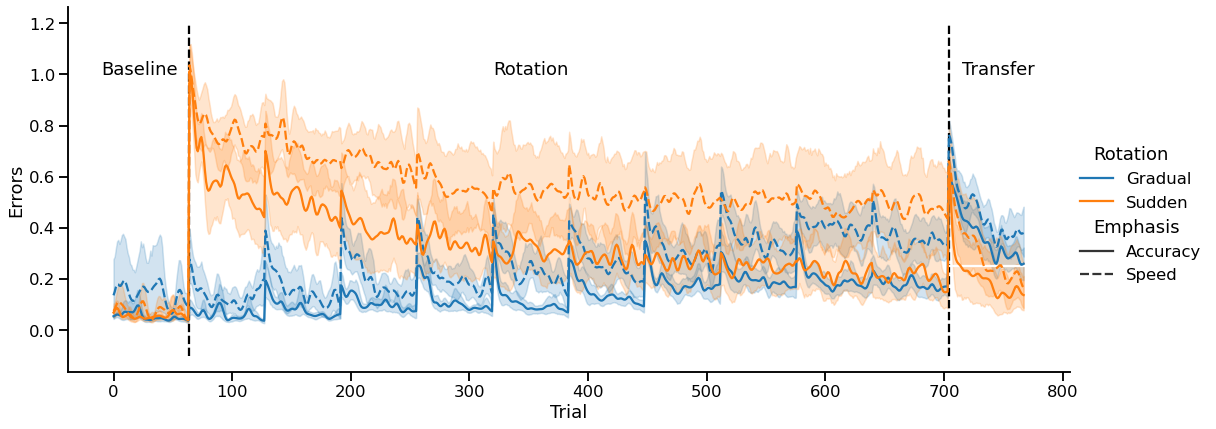

In [24]:
sns.set_context('talk')

rp = sns.relplot(x = 'Trial', y = 'Errors', hue = 'Rotation', style = 'Emphasis', 
            hue_order = ['Gradual', 'Sudden'], style_order = ['Accuracy', 'Speed'],
            data = errors[errors['Block'] < 12], height = 6, aspect = 2.5, kind = 'line')

plt.vlines(x = 64, ymax=1.2, ymin = -0.1, color = 'black', linestyles = '--')
plt.vlines(x = 704, ymax=1.2, ymin = -0.1, color = 'black', linestyles = '--')
plt.hlines(xmin = 704, xmax = 768, y = 0.25, color = 'white')
plt.text(x = -10, y = 1, s = 'Baseline')
plt.text(x = 320, y = 1, s = 'Rotation')
plt.text(x = 715, y = 1, s = 'Transfer')
sns.despine(bottom=False, left=False)


Text(730, 0.7, 'Block 11')

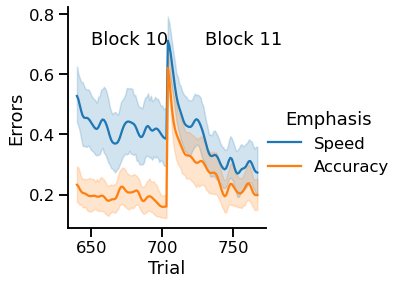

In [80]:
sns.relplot(x = 'Trial', y = 'Errors', hue = 'Emphasis', data = errors.loc[(errors['Block'] == 10) | (errors['Block'] == 11)], height = 4, aspect = 1, kind = 'line')
plt.text(650, 0.7, 'Block 10')
plt.text(730, 0.7, 'Block 11')

In [4]:
block_wise = errors.groupby(['Participant_Id', 'Block', 'Rotation', 'Emphasis', 'Condition']).mean().reset_index()

In [26]:
block10_11_emphasis = block_wise.loc[(block_wise['Block'] == 10) | (block_wise['Block'] == 11)].groupby(['Participant_Id', 'Block', 'Emphasis']).mean().reset_index()

In [6]:
model = smf.ols('Errors~Block*Rotation*Emphasis', data = block_wise.loc[(block_wise['Block'] == 10) | (block_wise['Block'] == 11)]).fit()
aov = sm.stats.anova_lm(model, typ = 2)
aov

,sum_sq,df,F,PR(>F)
Rotation,0.039467,1.0,1.163910,0.282974
Emphasis,0.770620,1.0,22.726216,0.000006
Rotation:Emphasis,0.024312,1.0,0.716990,0.398939
Block,0.021883,1.0,0.645361,0.423478
Block:Rotation,0.410846,1.0,12.116182,0.000713
Block:Emphasis,0.141408,1.0,4.170229,0.043489
Block:Rotation:Emphasis,0.015615,1.0,0.460491,0.498794
Residual,3.797790,112.0,NaN,NaN


In [27]:
model = smf.ols('Errors~Block*Emphasis', data = block10_11_emphasis).fit()
aov = sm.stats.anova_lm(model, typ = 2)
aov

,sum_sq,df,F,PR(>F)
Emphasis,0.770620,1.0,20.846843,0.000012
Block,0.021883,1.0,0.591992,0.443214
Block:Emphasis,0.141408,1.0,3.825367,0.052887
Residual,4.288030,116.0,NaN,NaN


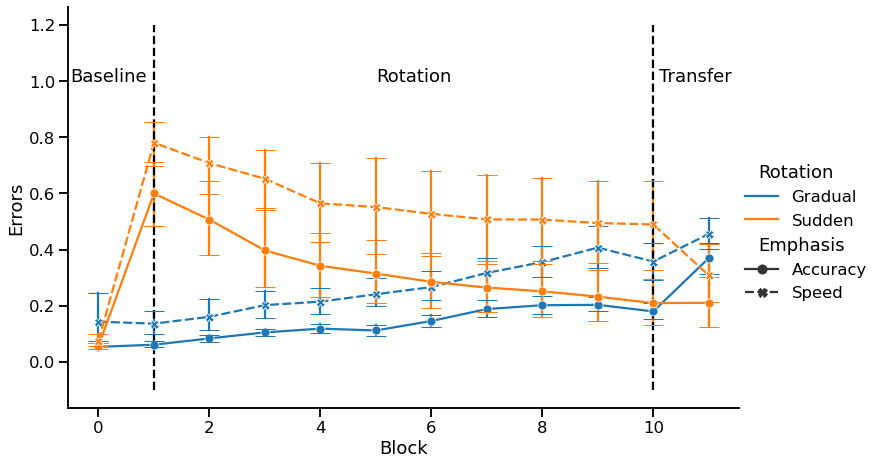

In [64]:
sns.set_context('talk')
sns.relplot(x = 'Block', y = 'Errors', hue = 'Rotation', style = 'Emphasis', 
            hue_order = ['Gradual', 'Sudden'], style_order = ['Accuracy', 'Speed'],
            data = block_wise, height = 6.5, aspect = 1.6, kind = 'line', markers = True, 
            err_style = 'bars', err_kws = {"capsize": 10})

plt.vlines(x = 1, ymax=1.2, ymin = -0.1, color = 'black', linestyles = '--')
plt.vlines(x = 10, ymax=1.2, ymin = -0.1, color = 'black', linestyles = '--')
plt.text(x = -0.5, y = 1, s = 'Baseline')
plt.text(x = 5, y = 1, s = 'Rotation')
plt.text(x = 10.1, y = 1, s = 'Transfer')
sns.despine(bottom=False, left=False)


Text(0.5, 0.7671550519495975, 'Block 10')

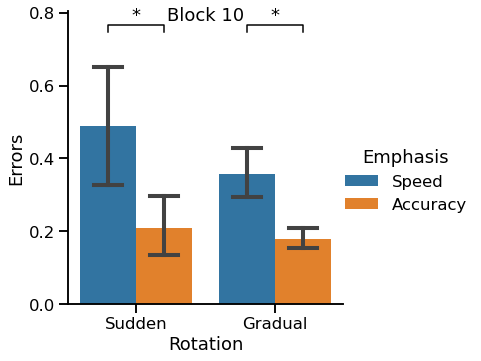

In [78]:
sns.catplot(x = 'Rotation', y = 'Errors', hue = 'Emphasis', 
            data = block_wise.loc[(block_wise['Block'] == 10)],  capsize = 0.2, kind = 'bar')

x1, x2 = 0.8, 1.2
y, h, col = block_wise.loc[(block_wise['Block'] == 10)]['Errors'].max()-0.3, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)

x1, x2 = -0.2, 0.2
y, h, col = block_wise.loc[(block_wise['Block'] == 10)]['Errors'].max()-0.3, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
plt.text(0.5, y+h, "Block 10", ha='center', va='bottom', color=col)

Text(0.5, 0.5916721119172326, 'Block 11')

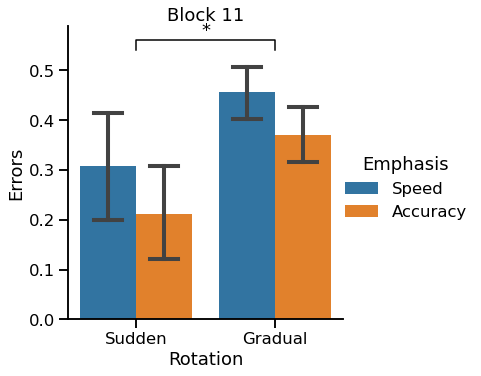

In [77]:
sns.catplot(x = 'Rotation', y = 'Errors', hue = 'Emphasis', 
            data = block_wise.loc[(block_wise['Block'] == 11)], kind = 'bar', capsize = 0.2)

x1, x2 = 0, 1
y, h, col = block_wise.loc[(block_wise['Block'] == 11)]['Errors'].max()-0.2, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)

plt.text(0.5, y+h+0.03, "Block 11", ha='center', va='bottom', color=col)